<a href="https://colab.research.google.com/github/VladimirVladetic/OSiRV-RoadSignDetection/blob/main/EDA_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pybboxes
! pip install kaggle

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import shutil
from imblearn.under_sampling import RandomUnderSampler
import xml.etree.ElementTree as ET
import pybboxes as pbx
from collections import defaultdict
from google.colab import files

In [3]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [4]:
! kaggle datasets download -d andrewmvd/road-sign-detection
with zipfile.ZipFile('/content/road-sign-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')
annotations_path = '/content/annotations'
annotations = os.listdir(annotations_path)

 99% 215M/218M [00:07<00:00, 34.2MB/s]
100% 218M/218M [00:07<00:00, 29.7MB/s]


In [5]:
from PIL import ImageOps

def extract_features_contrast(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = Image.fromarray(image, mode='RGB')
        var_img = ImageOps.equalize(var_img, mask=None) ## Contrast enhancement
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [6]:
from skimage import feature

def extract_features_edge(images, height, width):
    features = []
    for var_img  in tqdm(images):
        edge_channels = [feature.canny(var_img[:, :, i]) for i in range(3)]
        edges = np.stack(edge_channels, axis=-1)
        edges_image = Image.fromarray(edges.astype(np.uint8) * 255)
        edges_image = edges_image.resize((height, width), Image.ANTIALIAS)
        edges_image = np.array(edges_image)
        edges_image = edges_image / 255.0
        features.append(edges_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [7]:
import imgaug.augmenters as iaa
import numpy as np
import cv2
import pandas as pd
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def augment_data(images, annotations, class_int):
    annotations = annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(
            rotate=(-10, 10),
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}
        )
    ])

    augmented_images = []
    augmented_annotations = []

    for image, annotation, label in zip(images, annotations, class_int):
        bbs = [BoundingBox(x1=annotation[0], y1=annotation[1], x2=annotation[2], y2=annotation[3], label=label)]
        augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)
        augmented_images.append(augmented_image)
        augmented_annotations.append(augmented_bbs)

    return augmented_images, augmented_annotations

In [8]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append("/content/images/" + img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

  0%|          | 0/877 [00:00<?, ?it/s]

In [9]:
df = pd.DataFrame({
                        'image_path': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'class_label': label_list})

classes = df['class_label'].unique().tolist()
classes

df['class_int'] = df['class_label'].apply(lambda x: classes.index(x))
df.head()

,image_path,width,height,xmin,ymin,xmax,ymax,class_label,class_int
0,/content/images/road21.png,300,400,135,53,154,91,trafficlight,0
1,/content/images/road21.png,300,400,82,169,97,199,trafficlight,0
2,/content/images/road21.png,300,400,162,57,186,105,trafficlight,0
3,/content/images/road21.png,300,400,97,172,108,198,trafficlight,0
4,/content/images/road21.png,300,400,134,96,153,110,trafficlight,0


In [25]:
images = [cv2.imread(image_path) for image_path in df['image_path']]
annotations = df[['xmin', 'ymin', 'xmax', 'ymax']]
annotations[['xmin', 'ymin', 'xmax', 'ymax']] = annotations[['xmin', 'ymin', 'xmax', 'ymax']].astype(float)

augmented_images, augmented_annotations = augment_data(images, annotations, df['class_int'])

max_boxes = max(len(bb_list) for bb_list in augmented_annotations)
padded_annotations = [bb_list + [BoundingBox(0, 0, 0, 0)] * (max_boxes - len(bb_list)) for bb_list in augmented_annotations]
# augmented_annotations = np.array(padded_annotations)
augmented_annotations = padded_annotations

image_dimensions = 224

fixed_size = (image_dimensions, image_dimensions)
augmented_images_resized = [cv2.resize(image, fixed_size) for image in augmented_images]
augmented_images = np.array(augmented_images_resized)

In [26]:
X = augmented_images
y = augmented_annotations

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [28]:
print(y_train)

[[BoundingBox(x1=92.2351, y1=182.0314, x2=127.8518, y2=223.0647, label=1)], [BoundingBox(x1=151.0213, y1=264.2716, x2=199.6766, y2=314.0622, label=1)], [BoundingBox(x1=195.5952, y1=279.2781, x2=270.2726, y2=346.7922, label=1)], [BoundingBox(x1=168.8781, y1=249.1765, x2=209.5155, y2=305.2261, label=1)], [BoundingBox(x1=173.5330, y1=50.0852, x2=217.7172, y2=102.9624, label=3)], [BoundingBox(x1=84.7483, y1=257.4441, x2=109.5344, y2=294.8740, label=0)], [BoundingBox(x1=103.0471, y1=253.9835, x2=112.8424, y2=266.4849, label=1)], [BoundingBox(x1=174.5049, y1=226.6416, x2=186.3655, y2=247.7498, label=0)], [BoundingBox(x1=196.5849, y1=187.0134, x2=229.9850, y2=229.9208, label=2)], [BoundingBox(x1=-38.1286, y1=25.7522, x2=269.0217, y2=300.0925, label=3)], [BoundingBox(x1=-5.3345, y1=278.5555, x2=29.2413, y2=333.8712, label=2)], [BoundingBox(x1=110.1431, y1=152.7823, x2=184.8637, y2=228.0936, label=2)], [BoundingBox(x1=133.1073, y1=193.1245, x2=183.7699, y2=233.9900, label=1)], [BoundingBox(x1=1

In [17]:
features = extract_features_contrast(X_train,image_dimensions,image_dimensions)

  0%|          | 0/995 [00:00<?, ?it/s]

In [18]:
from tensorflow.keras.applications import VGG16

vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False

# max-pooling is output of VGG, flattening it further
flatten = vgg.output
flatten = Flatten()(flatten)

58889256/58889256 [==============================] - 2s 0us/step


In [19]:
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(4, activation="softmax", name="class_label")(softmaxHead)

In [20]:
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

In [46]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 64
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5)

In [50]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

trainBBoxes = []

for boxes in y_train:
  for box in boxes:
    x1 = box.x1
    y1 = box.y1
    x2 = box.x2
    y2 = box.y2

    trainBBoxes.append([x1, y1, x2, y2])

trainBBoxes = np.array(trainBBoxes)

trainLabels = []

for boxes in y_train:
  for box in boxes:
    label = box.label
    trainLabels.append(label)

trainLabels = np.array(trainLabels)
trainLabels = lb.fit_transform(trainLabels)

testBBoxes = []

for boxes in y_test:
  for box in boxes:
    x1 = box.x1
    y1 = box.y1
    x2 = box.x2
    y2 = box.y2

    testBBoxes.append([x1, y1, x2, y2])

testBBoxes = np.array(testBBoxes)

testLabels = []

for boxes in y_test:
  for box in boxes:
    label = box.label
    testLabels.append(label)

testLabels = np.array(testLabels)
testLabels = lb.fit_transform(testLabels)

In [51]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

In [52]:
opt = Adam(INIT_LR)

model.compile(loss=losses,
              optimizer=opt,
              metrics=["accuracy"],
              loss_weights=lossWeights,
              run_eagerly=True)

In [ ]:
print(len(features))
print(features)

In [ ]:
print(len(trainTargets))
print(trainTargets)

In [53]:
history = model.fit(
    features, trainTargets,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,lr],
    verbose=1)

Epoch 1/25


13/13 [==============================] - 69s 3s/step - loss: 38079.7773 - bounding_box_loss: 38078.4531 - class_label_loss: 1.3236 - bounding_box_accuracy: 0.5038 - class_label_accuracy: 0.5364 - val_loss: 38704.3828 - val_bounding_box_loss: 38703.4258 - val_class_label_loss: 0.9562 - val_bounding_box_accuracy: 0.6633 - val_class_label_accuracy: 0.6734 - lr: 1.0000e-04
Epoch 2/25
13/13 [==============================] - 17s 1s/step - loss: 37997.5938 - bounding_box_loss: 37996.5391 - class_label_loss: 1.0548 - bounding_box_accuracy: 0.6683 - class_label_accuracy: 0.5967 - val_loss: 38692.0586 - val_bounding_box_loss: 38691.1562 - val_class_label_loss: 0.9020 - val_bounding_box_accuracy: 0.6734 - val_class_label_accuracy: 0.6734 - lr: 1.0000e-04
Epoch 3/25
13/13 [==============================] - 17s 1s/step - loss: 37992.6875 - bounding_box_loss: 37991.6992 - class_label_loss: 0.9895 - bounding_box_accuracy: 0.6671 - class_label_accuracy: 0.6269 - val_loss: 38691.1719 - val_bounding_bo

KeyboardInterrupt: 

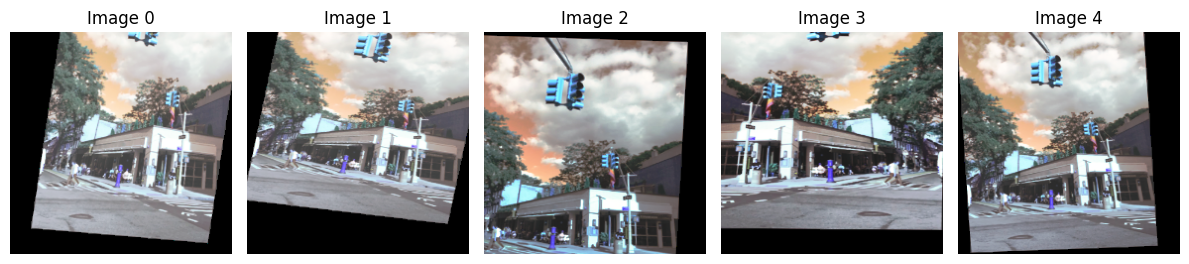

In [14]:
import matplotlib.pyplot as plt
indices_to_display = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = features[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Input

def generate_proposals(features):
    backbone = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(None, None, 3)))
    rpn_conv = Conv2D(256, (3, 3), activation='relu', padding='same', name='rpn_conv')(backbone.output)
    rpn_class = Conv2D(2, (1, 1), activation='softmax', name='rpn_class')(rpn_conv)
    rpn_bbox = Conv2D(4, (1, 1), activation='linear', name='rpn_bbox')(rpn_conv)
    rpn_model = tf.keras.Model(backbone.input, [rpn_class, rpn_bbox], name='rpn_model')
    proposals = rpn_model.predict(features)
    return proposals

In [ ]:
proposals = generate_proposals(features)

39/39 [==============================] - 5s 88ms/step


In [ ]:
print(proposals)

[array([[[[0.43137246, 0.56862754],
         [0.4107263 , 0.5892737 ],
         [0.41482848, 0.5851715 ],
         ...,
         [0.36603162, 0.63396835],
         [0.5011034 , 0.49889663],
         [0.6337467 , 0.36625335]],

        [[0.24174741, 0.7582526 ],
         [0.29993376, 0.7000662 ],
         [0.24033311, 0.7596669 ],
         ...,
         [0.15840322, 0.8415967 ],
         [0.2535965 , 0.7464035 ],
         [0.68340355, 0.3165964 ]],

        [[0.17942719, 0.8205728 ],
         [0.22446132, 0.7755387 ],
         [0.10184782, 0.89815223],
         ...,
         [0.06785337, 0.9321466 ],
         [0.17852204, 0.821478  ],
         [0.6109439 , 0.38905615]],

        ...,

        [[0.22099645, 0.77900356],
         [0.22915499, 0.770845  ],
         [0.15421133, 0.84578866],
         ...,
         [0.2284244 , 0.7715756 ],
         [0.16879714, 0.83120286],
         [0.5409122 , 0.45908782]],

        [[0.36528346, 0.6347165 ],
         [0.3420846 , 0.6579154 ],
         [0

In [ ]:
from tensorflow.keras.layers import Lambda
import tensorflow as tf

def extract_features_from_roi(image_features, proposal):
    xmin, ymin, xmax, ymax = tf.unstack(proposal[..., 1:], axis=-1)
    roi_features = tf.image.crop_and_resize(
        image_features,
        boxes=tf.stack([ymin, xmin, ymax, xmax], axis=-1),
        box_indices=tf.zeros_like(xmin),
        crop_size=(7, 7)  # Assuming pool size is (7, 7)
    )
    return roi_features

def roi_pooling(features, proposals):
    def roi_pooling_layer(inputs):
        features, probabilities, coordinates = inputs

        # Extract bounding box coordinates from the coordinates tensor
        xmin, ymin, xmax, ymax = tf.unstack(coordinates, axis=-1)

        # Perform ROI pooling using tf.image.crop_and_resize
        pooled_features = tf.image.crop_and_resize(
            features,
            boxes=tf.stack([ymin, xmin, ymax, xmax], axis=-1),
            box_indices=tf.zeros_like(xmin, dtype=tf.int32),
            crop_size=(7, 7)  # Assuming pool size is (7, 7)
        )

        return pooled_features

    # Use Lambda layer to apply the roi_pooling_layer function
    pooled_features = Lambda(roi_pooling_layer)([features, *proposals])

    return pooled_features

In [ ]:
roi_features = roi_pooling(features, proposals)

InvalidArgumentError: Exception encountered when calling layer 'lambda_3' (type Lambda).

{{function_node __wrapped__CropAndResize_device_/job:localhost/replica:0/task:0/device:GPU:0}} box_indices must be rank 1 but is shape [1244,7,7] [Op:CropAndResize]

Call arguments received by layer 'lambda_3' (type Lambda):
  • inputs=['tf.Tensor(shape=(1244, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(1244, 7, 7, 2), dtype=float32)', 'tf.Tensor(shape=(1244, 7, 7, 4), dtype=float32)']
  • mask=None
  • training=None

In [ ]:
# Perform ROI pooling
roi_features = roi_pooling(features, proposals)

# Train R-CNN model
rcnn_model = build_rcnn_model()
rcnn_model.compile(optimizer='adam', loss=['categorical_crossentropy', 'smooth_l1'])

rcnn_model.fit(roi_features, [augmented_annotations['class_int'], augmented_annotations[['xmin', 'ymin', 'xmax', 'ymax']]])

# After training, use the model for inference
predictions = rcnn_model.predict(test_images)

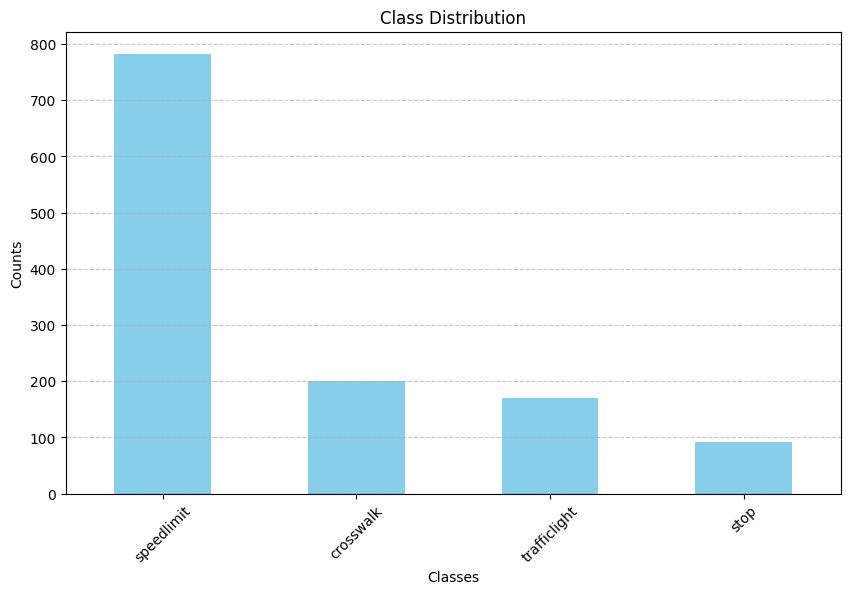

In [ ]:
class_counts = df['class_label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['width'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df['height'], bins=30, color='red', edgecolor='black')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()